# Loading the data

In [ ]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import cv2
IMG_WIDTH=32
IMG_HEIGHT=30
IMG_FOLDER=r'Data/'

def create_dataset(img_folder):
  img_data_array=[]
  class_name=[]
  for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder, dir1)):
      image_path = os.path.join(img_folder, dir1, file)
      image = cv2.imread( image_path, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),
      interpolation = cv2.INTER_AREA)
      image = np.array(image)
      image = image.astype('float32')
      image /= 255
      img_data_array.append(image)
      class_name.append(dir1)
  return img_data_array, class_name

# Extract the image array and class name
img_data, class_name = create_dataset(IMG_FOLDER)
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
# Convert the class_names to their respective numeric value based on the dictionary
target_val = [target_dict[class_name[i]] for i in range(len(class_name))]
# Convert to X - a 3d array (samples, width, height) and y - 0/1
X = tf.cast(np.array(img_data), tf.float64)
y = tf.cast(list(map(int,target_val)),tf.int32)
X = np.array(X)
y = np.array(y)

Split your dataset into a train and test set using sklearn's `train_test_split` function.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the models to search for optimal hyperparameters

Define CNN model using a library

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(32, 30, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(units=128, activation='relu'))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

Define the hyperparameters that we want to test during grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

param_grid = {'epochs': [5, 10, 15, 20],
              'batch_size': [32, 64, 128]}

Use GridSearchCV to find the optimal hyperparameters - **Using optimizer 'adam'**

In [ ]:
model = KerasClassifier(build_fn=create_model)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

<ipython-input-5-1de469b936ea>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


Epoch 1/20
16/16 [==============================] - 1s 27ms/step - loss: 0.7014 - accuracy: 0.5271
Epoch 2/20
16/16 [==============================] - 0s 26ms/step - loss: 0.6694 - accuracy: 0.6052
Epoch 3/20
16/16 [==============================] - 0s 26ms/step - loss: 0.6348 - accuracy: 0.6633
Epoch 4/20
16/16 [==============================] - 0s 28ms/step - loss: 0.5827 - accuracy: 0.7074
Epoch 5/20
16/16 [==============================] - 0s 27ms/step - loss: 0.5246 - accuracy: 0.7876
Epoch 6/20
16/16 [==============================] - 0s 27ms/step - loss: 0.4615 - accuracy: 0.8257
Epoch 7/20
16/16 [==============================] - 0s 26ms/step - loss: 0.4160 - accuracy: 0.8617
Epoch 8/20
16/16 [==============================] - 0s 28ms/step - loss: 0.3711 - accuracy: 0.8697
Epoch 9/20
16/16 [==============================] - 0s 27ms/step - loss: 0.3515 - accuracy: 0.8918
Epoch 10/20
16/16 [==============================] - 0s 27ms/step - loss: 0.3116 - accuracy: 0.9038
Epoch 11/

Use the best hyperparameters to train the CNN model on the entire train set.


In [ ]:
best_param = grid.best_params_
model = create_model()
history = model.fit(X_train, y_train, epochs=best_param['epochs'], batch_size=best_param['batch_size'],
                    validation_data=(X_test, y_test))

Epoch 1/20
16/16 [==============================] - 1s 41ms/step - loss: 0.6758 - accuracy: 0.6092 - val_loss: 0.7048 - val_accuracy: 0.4240
Epoch 2/20
16/16 [==============================] - 0s 29ms/step - loss: 0.6057 - accuracy: 0.7074 - val_loss: 0.6276 - val_accuracy: 0.5680
Epoch 3/20
16/16 [==============================] - 0s 30ms/step - loss: 0.5413 - accuracy: 0.7495 - val_loss: 0.5339 - val_accuracy: 0.6720
Epoch 4/20
16/16 [==============================] - 0s 29ms/step - loss: 0.5161 - accuracy: 0.7455 - val_loss: 0.4337 - val_accuracy: 0.8480
Epoch 5/20
16/16 [==============================] - 0s 30ms/step - loss: 0.4175 - accuracy: 0.8577 - val_loss: 0.4111 - val_accuracy: 0.8480
Epoch 6/20
16/16 [==============================] - 0s 30ms/step - loss: 0.3676 - accuracy: 0.8717 - val_loss: 0.3181 - val_accuracy: 0.9120
Epoch 7/20
16/16 [==============================] - 0s 29ms/step - loss: 0.3228 - accuracy: 0.8858 - val_loss: 0.3076 - val_accuracy: 0.9040
Epoch 8/20
16

Now, we will performed the same steps **using optimizer 'sgd'**

In [ ]:
def create_model_sgd():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(32, 30, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(units=128, activation='relu'))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model_sgd = KerasClassifier(build_fn=create_model_sgd)
grid_sgd = GridSearchCV(estimator=model_sgd, param_grid=param_grid, scoring="accuracy", n_jobs=-1, cv=3)
grid_result_sgd = grid_sgd.fit(X_train, y_train)

Epoch 1/20
16/16 [==============================] - 1s 25ms/step - loss: 0.6943 - accuracy: 0.4870
Epoch 2/20
16/16 [==============================] - 0s 24ms/step - loss: 0.6922 - accuracy: 0.5571
Epoch 3/20
16/16 [==============================] - 0s 24ms/step - loss: 0.6908 - accuracy: 0.6012
Epoch 4/20
16/16 [==============================] - 0s 25ms/step - loss: 0.6899 - accuracy: 0.6012
Epoch 5/20
16/16 [==============================] - 0s 25ms/step - loss: 0.6891 - accuracy: 0.5511
Epoch 6/20
16/16 [==============================] - 0s 27ms/step - loss: 0.6881 - accuracy: 0.6092
Epoch 7/20
16/16 [==============================] - 0s 24ms/step - loss: 0.6875 - accuracy: 0.5351
Epoch 8/20
16/16 [==============================] - 0s 25ms/step - loss: 0.6866 - accuracy: 0.5271
Epoch 9/20
16/16 [==============================] - 0s 25ms/step - loss: 0.6861 - accuracy: 0.5812
Epoch 10/20
16/16 [==============================] - 0s 25ms/step - loss: 0.6856 - accuracy: 0.5411
Epoch 11/

In [ ]:
best_param_sgd = grid_sgd.best_params_
model_sgd = create_model_sgd()
history_sgd = model_sgd.fit(X_train, y_train, epochs=best_param_sgd['epochs'], batch_size=best_param_sgd['batch_size'],
                    validation_data=(X_test, y_test))

Epoch 1/20
16/16 [==============================] - 1s 40ms/step - loss: 0.6929 - accuracy: 0.4950 - val_loss: 0.6945 - val_accuracy: 0.4000
Epoch 2/20
16/16 [==============================] - 0s 28ms/step - loss: 0.6918 - accuracy: 0.5291 - val_loss: 0.6946 - val_accuracy: 0.4160
Epoch 3/20
16/16 [==============================] - 0s 29ms/step - loss: 0.6911 - accuracy: 0.5311 - val_loss: 0.6949 - val_accuracy: 0.4240
Epoch 4/20
16/16 [==============================] - 0s 27ms/step - loss: 0.6907 - accuracy: 0.5391 - val_loss: 0.6947 - val_accuracy: 0.4240
Epoch 5/20
16/16 [==============================] - 0s 29ms/step - loss: 0.6901 - accuracy: 0.5291 - val_loss: 0.6947 - val_accuracy: 0.4240
Epoch 6/20
16/16 [==============================] - 0s 29ms/step - loss: 0.6896 - accuracy: 0.5351 - val_loss: 0.6947 - val_accuracy: 0.4240
Epoch 7/20
16/16 [==============================] - 1s 32ms/step - loss: 0.6890 - accuracy: 0.5311 - val_loss: 0.6950 - val_accuracy: 0.4240
Epoch 8/20
16

# Evaluation

evaluate the model on the test set to get an idea of its performance on unseen data:

**using adam optimizer**

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

4/4 [==============================] - 0s 9ms/step - loss: 0.0833 - accuracy: 0.9760
Test accuracy: 0.9760000109672546


4/4 [==============================] - 0s 9ms/step - loss: 0.0833 - accuracy: 0.9760


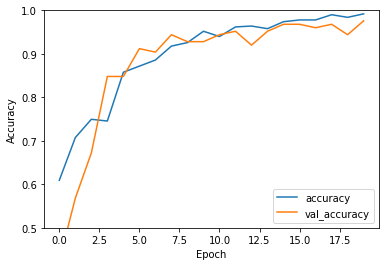

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

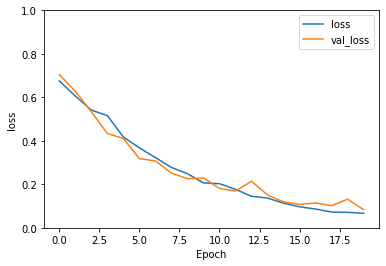

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='uper right')

**using sgd optimizer**

In [ ]:
test_loss_sgd, test_acc_sgd = model_sgd.evaluate(X_test, y_test)
print('Test accuracy:', test_acc_sgd)

4/4 [==============================] - 0s 9ms/step - loss: 0.6883 - accuracy: 0.5360
Test accuracy: 0.5360000133514404


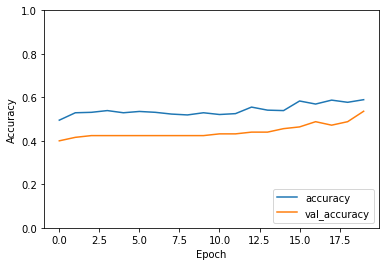

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_sgd.history['accuracy'], label='accuracy')
plt.plot(history_sgd.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

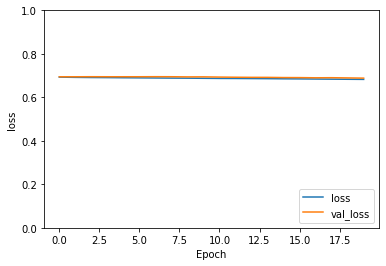

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_sgd.history['loss'], label='loss')
plt.plot(history_sgd.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Answers for the questions

1. Does the model overfit?
- **Answer:** We can see from the learning plot that while using `adam` optimizer the model doesn't overfit because the plot of training loss decreases to a point of stability ang the plot of validation loss decreases to a point of stability also and has a small gap with the training loss.

2. What's the effect of batch size? In general, do you see this effect in the current task?
- **Answer:** The batch size in a CNN model determines the number of samples that will be processed before the model's weights are updated. A larger batch size can lead to more stable gradients and faster training times, but it also requires more memory. Conversely, a smaller batch size can require less memory, but can lead to more noisy gradients and slower training times.
In the current task we can see that the grid search chose the lowest batch size, therefore we assume that as we increase the batch size we get worst results.

3. What was the optimal optimizer? Explain.
- **Answer:** The optimal optimizer is `adam` optimizer becuase as we can see its performance was better according to accuracy score and loss.